In [4]:
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams["font.family"] = "serif"

%matplotlib inline
plt.rcParams["figure.dpi"] = 300

,surface,glacier,est_ground
0,NaN,1271.18880,NaN
10,1271.322467,1295.62663,NaN
20,1271.457313,1298.01876,NaN
30,1271.592160,1300.64673,NaN
40,1271.672157,1303.55835,NaN


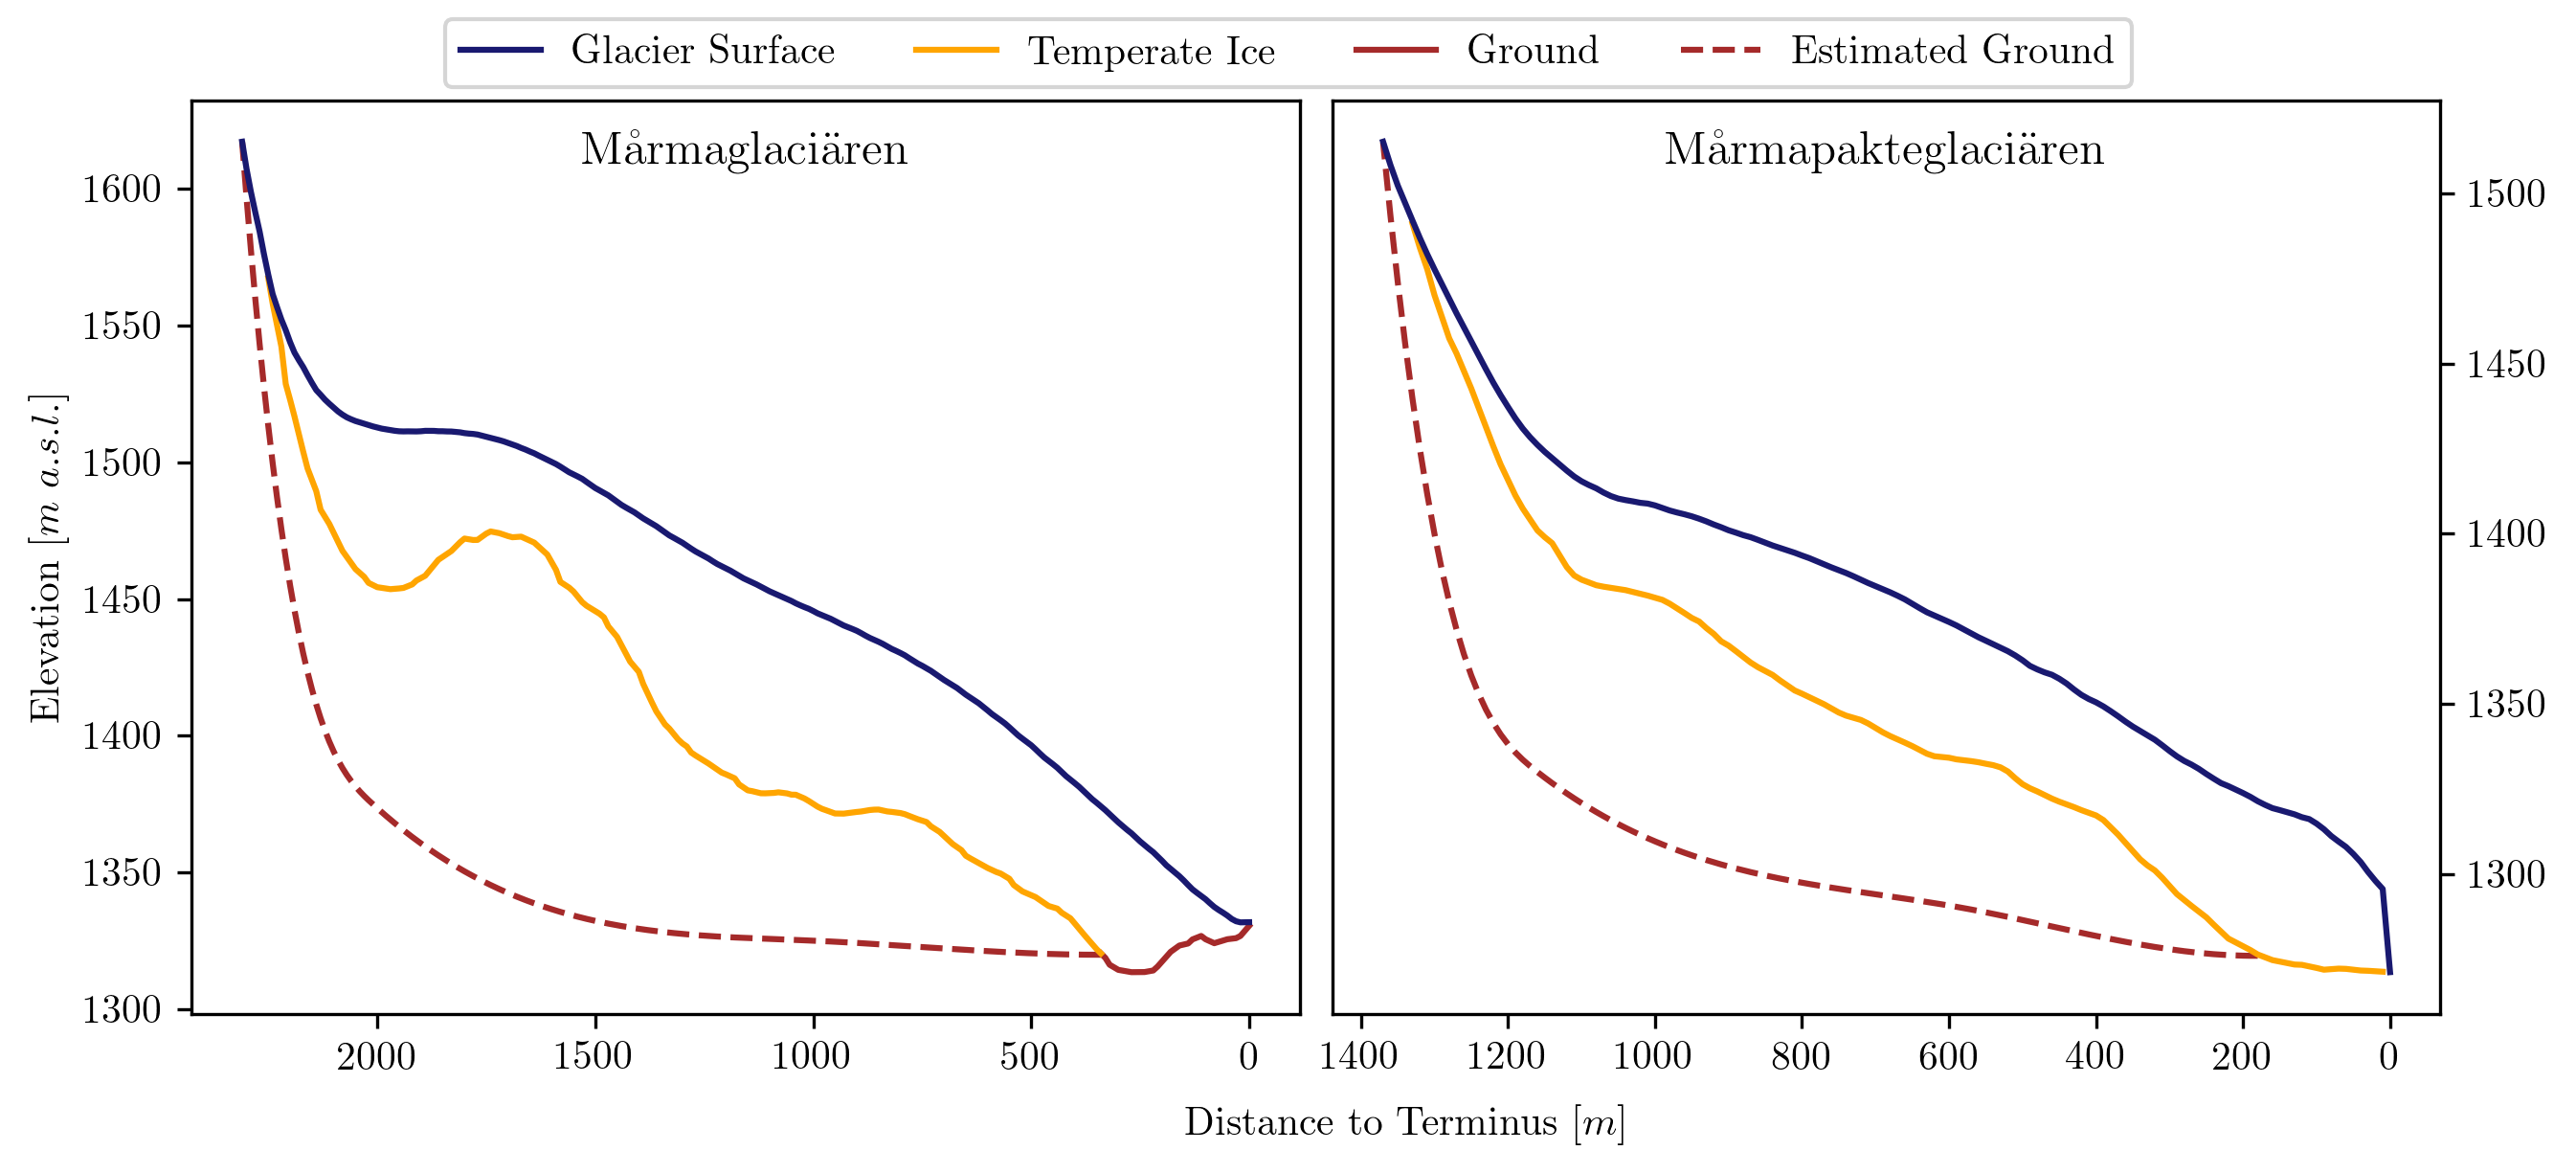

In [221]:
marpak = pd.read_csv("MarPak_profile_180511.csv").rolling(3).mean().dropna()
marma = pd.read_csv("profile_180510.csv").rolling(3).mean().dropna()                    

# Last 36 points are ground. Rest is temperate ice
marma["ground"] = marma["surface"].iloc[:35]
marma["surface"] = marma["surface"].iloc[34:]  # With some visually good overlap

# Fix ice front for marpak
marpak.loc[2,  ["glacier"]] = marpak.loc[2, "surface"]
marpak.sort_index(inplace=True)

# Estimated ground values, to be interpolated
est_grounds = [
    {200: 1276, 210: 1276, 600: 1290, 1180: 1330, 1300: 1380, 1390: 1515},
    {360: 1320, 370: 1320, 1000: 1325, 2030: 1375, 2220: 1455, 2330: 1617}
]

# Fix index to represent meters and fix values
for i, df in enumerate([marpak, marma]):
    df.index *= 10
        
    # Remove values where temperate is higher than glacier
    df["surface"] = df["surface"][df["surface"] < df["glacier"]]
    
    # Interpolate an estimated ground
    df.loc[:, "est_ground"] = pd.Series(est_grounds[i])
    df.loc[:, "est_ground"] = df.loc[:, "est_ground"].interpolate(method="spline", order=3, s=0.)
    
    # Align index to zero (AFTER est_ground JOINING)
    df.index -= df.index.min()


fig = plt.figure(figsize=(9, 4))

colors = ["midnightblue", "orange", "brown", "brown"]
labels = ["Glacier Surface", "Temperate Ice", "Ground", "Estimated Ground"]
titles = ["Mårmaglaciären", "Mårmapakteglaciären"]
subplots = [121, 122]

for i1, df in enumerate([marma, marpak]):
    plt.subplot(subplots[i1])
    
    for i2, col in enumerate(["glacier", "surface", "ground", "est_ground"]):
        
        # Skip ground for marpak (no values)
        if col == "ground" and i1 == 1:
            continue
        plt.plot(df[col], c=colors[i2], zorder=3 - i2,
                 label=(labels[i2] if i1 == 0 else "_nolegend_"),
                 linestyle="-" if i2 != 3 else "--")
        
    if i1 == 0:
        plt.ylabel("Elevation $[m\ a.s.l.$]")
    elif i1 == 1:
        plt.gca().yaxis.tick_right()
    
    plt.text(0.5, 0.93, titles[i1], transform=plt.gca().transAxes, ha="center", fontsize=12)  # Titles
    #plt.legend(loc="lower left")
    plt.gca().invert_xaxis()

plt.figlegend(loc="upper center", ncol=4) 

plt.text(0.54, 0.02, "Distance to Terminus $[m]$", transform=fig.transFigure, ha="center")
plt.subplots_adjust(left=0.07, bottom=None, right=0.94, top=0.92, wspace=0.03, hspace=None)

#plt.savefig("export/Comb_cross_section_180511", dpi=300)


marpak.head()